In [22]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np
#https://www.kaggle.com/c/data-science-bowl-2018/data

In [23]:
def conv_block(inputs, filters, kernel_size=3):
    x= inputs
    for i in range(2):
        x= tf.keras.layers.Conv2D(filters, kernel_size, kernel_initializer="he_normal",
                                 padding="same")(x)
        x= tf.keras.layers.Activation("relu")(x)
    return x
    

In [24]:
def encoder_block(inputs, filters=64):
    f= conv_block(inputs, filters=filters) ##output for the concat
    p= tf.keras.layers.MaxPooling2D((2,2))(f)
    p= tf.keras.layers.Dropout(0.2)(p)
    return f, p
    

In [25]:
def encoder(inputs):
    filters=64
    f1, p1 = encoder_block(inputs, filters)
    f2, p2 = encoder_block(p1, filters*2)
    f3, p3 = encoder_block(p2, filters*4)
    f4, p4 = encoder_block(p3, filters*8)
    return p4, (f1, f2, f3, f4)

In [26]:
def bottleneck(inputs):
    bottle_neck = conv_block(inputs, 1024)
    return bottle_neck

In [27]:
def decoder_block(inputs, conv_out, filters=512, kernel_size=3, strides=2):
    u= tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides, padding="same")(inputs)
    cat= tf.keras.layers.concatenate([u, conv_out])
    cat= tf.keras.layers.Dropout(0.2)(cat)
    cat= conv_block(cat, filters, kernel_size)
    return cat

In [28]:
def decoder(inputs, convs, out_channels,filters=512,):
    f1, f2, f3, f4 = convs
    
    c6 = decoder_block(inputs, f4, filters)
    c7 = decoder_block(c6, f3, filters/2)
    c8= decoder_block(c7, f2, filters/4)
    c9= decoder_block(c8, f1, filters/8)
    
    outputs= tf.keras.layers.Conv2D(out_channels, 1, activation="sigmoid")(c9)
    return outputs

In [29]:
OUTPUT_CHANNELS=1
def unet():
    
    inputs= tf.keras.layers.Input(shape=(128, 128, 3))
    inputs= tf.keras.layers.Lambda(lambda x: x/255)(inputs)
    encoder_output, convs = encoder(inputs)
    bottle_neck= bottleneck(encoder_output)
    outputs= decoder(bottle_neck, convs, OUTPUT_CHANNELS)
    model= tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

model= unet()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 128, 128, 64  1792        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 activation_36 (Activation)     (None, 128, 128, 64  0           ['conv2d_38[1][0]']              
                                )                                                           

 activation_47 (Activation)     (None, 16, 16, 512)  0           ['conv2d_49[1][0]']              
                                                                                                  
 conv2d_transpose_9 (Conv2DTran  (None, 32, 32, 256)  1179904    ['activation_47[1][0]']          
 spose)                                                                                           
                                                                                                  
 concatenate_9 (Concatenate)    (None, 32, 32, 512)  0           ['conv2d_transpose_9[1][0]',     
                                                                  'activation_41[1][0]']          
                                                                                                  
 dropout_21 (Dropout)           (None, 32, 32, 512)  0           ['concatenate_9[1][0]']          
                                                                                                  
 conv2d_50

In [30]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [31]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]



In [32]:
import os
import numpy as np
import sys
import random
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
seed= 42
np.random.seed=seed

In [14]:
TRAIN_PATH="nuclei/stage1_train/"
TEST_PATH="nuclei/stage1_test/"

In [15]:
train_ids= next(os.walk(TRAIN_PATH))[1]
test_ids= next(os.walk(TEST_PATH))[1]

X_train= np.zeros((len(train_ids), 128, 128, 3), dtype=np.uint8)
Y_train= np.zeros((len(train_ids), 128, 128, 1), dtype=bool)

In [16]:
X_train.shape

(670, 128, 128, 3)

In [17]:
Y_train.shape

(670, 128, 128, 1)

In [18]:
for i, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path= TRAIN_PATH + id_
    img= imread(path+ "/images/" + id_ + ".png")[:,:,:3]
    img= resize(img, (128,128), mode='constant', preserve_range=True)
    X_train[i]=img
    mask=np.zeros((128,128,1), dtype=bool)
    for mask_file in next(os.walk(path + "/masks/"))[2]:
        mask_ = imread(path + "/masks/" + mask_file)
        mask_= np.expand_dims(resize(mask_, (128, 128), mode="constant",
                                    preserve_range=True), axis=-1)
        mask= np.maximum(mask, mask_)
    Y_train[i]= mask

100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [05:41<00:00,  1.96it/s]


In [33]:
X_test= np.zeros((len(test_ids), 128, 128, 3), dtype=np.uint8)
sizes_test=[]

In [34]:
for i, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path= TEST_PATH + id_
    img= imread(path+ "/images/" + id_ + ".png")[:,:,:3]
    sizes_test.append([img.shape[0], img.shape[1]])
    img= resize(img, (128,128), mode='constant', preserve_range=True)
    X_train[i]=img
    

100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 63.13it/s]


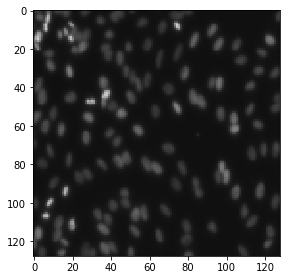

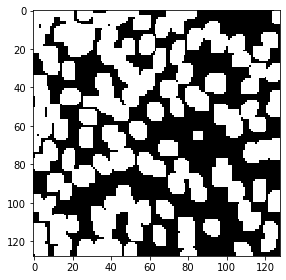

In [35]:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [36]:
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=32, epochs=100, callbacks=callbacks)

Epoch 1/100
19/19 [==============================] - 153s 8s/step - loss: 15.6368 - accuracy: 0.6114 - val_loss: 0.8324 - val_accuracy: 0.8270
Epoch 2/100
19/19 [==============================] - 156s 8s/step - loss: 0.7251 - accuracy: 0.8052 - val_loss: 0.5734 - val_accuracy: 0.8801
Epoch 3/100
19/19 [==============================] - 158s 8s/step - loss: 0.5866 - accuracy: 0.8505 - val_loss: 0.4981 - val_accuracy: 0.9199
Epoch 4/100
19/19 [==============================] - 158s 8s/step - loss: 0.5212 - accuracy: 0.8681 - val_loss: 0.3887 - val_accuracy: 0.9150
Epoch 5/100
19/19 [==============================] - 158s 8s/step - loss: 0.4887 - accuracy: 0.8594 - val_loss: 0.3233 - val_accuracy: 0.9209
Epoch 6/100
19/19 [==============================] - 157s 8s/step - loss: 0.4050 - accuracy: 0.8797 - val_loss: 0.2643 - val_accuracy: 0.9315
Epoch 7/100
19/19 [==============================] - 157s 8s/step - loss: 0.3512 - accuracy: 0.8778 - val_loss: 0.1889 - val_accuracy: 0.9353
Epoch

In [37]:
idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

3/3 [==============================] - 3s 837ms/step


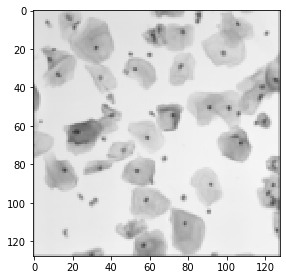

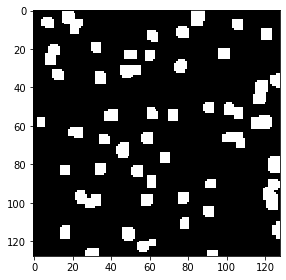

C:\Users\jpolo\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


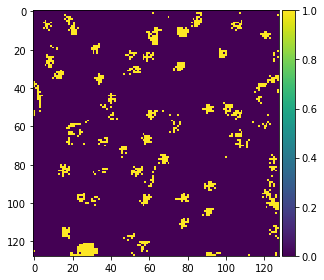

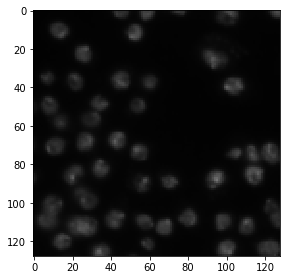

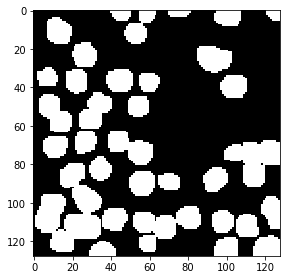

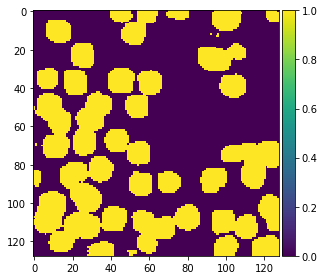

In [38]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

